In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [13]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
107035,00028876_039.png,Pneumothorax,39,28876,41,M,PA,2021,2020,0.194311,0.194311,NaN,../input/data/images_012/images/00028876_039.png,1.0
88535,00021930_010.png,No Finding,10,21930,52,F,AP,3056,2544,0.139000,0.139000,NaN,../input/data/images_010/images/00021930_010.png,0.0
14132,00003659_010.png,No Finding,10,3659,51,F,PA,2992,2991,0.143000,0.143000,NaN,../input/data/images_002/images/00003659_010.png,0.0


In [14]:
print('Before sampling...')
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)

print('After sampling...')
all_xray_df = all_xray_df.sample(22000, random_state=25)
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)
all_xray_df.sample(3)

Before sampling...
0.0    60361
1.0    51759
Name: Binary Labels, dtype: int64
After sampling...
0.0    11764
1.0    10236
Name: Binary Labels, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
40316,00010503_003.png,No Finding,3,10503,53,M,PA,2834,2989,0.143,0.143,NaN,../input/data/images_005/images/00010503_003.png,0.0
29612,00007708_009.png,No Finding,9,7708,33,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_004/images/00007708_009.png,0.0
36775,00009689_011.png,No Finding,11,9689,55,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_005/images/00009689_011.png,0.0


In [15]:
images = list(all_xray_df['path'])
labels = list(all_xray_df['Binary Labels'].map(lambda x: [x]))
train_img, val_img, train_label, val_label = train_test_split(images, labels, 
                                   test_size = 0.2, 
                                   random_state = 7,
                                   stratify = labels)
print('train:', len(train_img), '\nvalidation:', len(val_img))

train: 17600 
validation: 4400


In [16]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = nn.Sequential(nn.Linear(62720, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        x = self.out(x)
        return x

In [17]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [18]:
model = models.mnasnet0_5(pretrained=True)
model = Net(model)
#print(model)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet0_5_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
train = my_set(train_img, train_label, transform = my_transform)
trainloader = DataLoader(train, batch_size=64, shuffle=True, num_workers = 2)

val = my_set(val_img, val_label, transform = my_transform)
validloader = DataLoader(val, batch_size=64, shuffle=False, num_workers = 2)


valid_loss_min = np.Inf # track change in validation loss
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0002, momentum = 0.9 ,weight_decay=0.00002 )
optimizer = torch.optim.NAdam(params=model.parameters(), lr=0.00002, weight_decay=0.00002 )
n_epochs = 10

train_ac = []
test_ac = []
t_loss = []
v_loss = []

In [20]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [21]:
def training_loop(model):
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        model.train()
        train_correct = 0
        train_total = 0
        for data, target in trainloader:
            target = target.squeeze(1)
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_total += target.size(0)
            predicted = (output>0.5).float()
            train_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()

        # validate the model
        model.eval()
        valid_correct = 0
        valid_total = 0
        for data, target in validloader:
            target = target.squeeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_total += target.size(0)
            predicted = (output>0.5).float()
            valid_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        train_ac.append(100 * train_correct / train_total)
        test_ac.append(100 * valid_correct / valid_total) 

        print('Train Loss: {}'.format(train_loss))
        print('Validation Loss: {}'.format(valid_loss))
        print('Train Accuracy: {}'.format(100 * train_correct / train_total))
        print('Validation Accuracy: {}'.format(100 * valid_correct / valid_total))

In [22]:
training_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

running epoch: 1


 10%|█         | 1/10 [09:17<1:23:41, 557.92s/it]

Train Loss: 0.6642705178260804
Validation Loss: 0.675587275244973
Train Accuracy: 59.74431818181818
Validation Accuracy: 55.38636363636363
running epoch: 2


 20%|██        | 2/10 [17:39<1:09:55, 524.49s/it]

Train Loss: 0.6371119882843711
Validation Loss: 0.678185680996288
Train Accuracy: 64.625
Validation Accuracy: 55.63636363636363
running epoch: 3


 30%|███       | 3/10 [26:27<1:01:23, 526.24s/it]

Train Loss: 0.6210109593651512
Validation Loss: 0.6752408309416338
Train Accuracy: 66.7215909090909
Validation Accuracy: 56.86363636363637
running epoch: 4


 40%|████      | 4/10 [35:16<52:43, 527.33s/it]  

Train Loss: 0.6136787896806544
Validation Loss: 0.6716833728010004
Train Accuracy: 67.23863636363636
Validation Accuracy: 57.90909090909091
running epoch: 5


 50%|█████     | 5/10 [43:56<43:44, 524.89s/it]

Train Loss: 0.6059679568897595
Validation Loss: 0.6749757610667836
Train Accuracy: 67.89204545454545
Validation Accuracy: 58.06818181818182
running epoch: 6


 60%|██████    | 6/10 [52:35<34:50, 522.66s/it]

Train Loss: 0.5995153509486806
Validation Loss: 0.6664633284915578
Train Accuracy: 68.53977272727273
Validation Accuracy: 59.52272727272727
running epoch: 7


 70%|███████   | 7/10 [1:01:15<26:05, 521.74s/it]

Train Loss: 0.5962663517215036
Validation Loss: 0.6627726073698564
Train Accuracy: 68.9090909090909
Validation Accuracy: 60.15909090909091
running epoch: 8


 90%|█████████ | 9/10 [1:18:20<08:36, 516.19s/it]

Train Loss: 0.5842732294039292
Validation Loss: 0.6578035053339871
Train Accuracy: 69.6875
Validation Accuracy: 60.93181818181818
running epoch: 10


100%|██████████| 10/10 [1:26:19<00:00, 517.98s/it]

Train Loss: 0.5821796292608434
Validation Loss: 0.6485913996262984
Train Accuracy: 70.1590909090909
Validation Accuracy: 62.11363636363637


In [23]:
test_correct = 0
test_total = 0
pred_label = []
pred_for_roc_curve = []
for data, target in validloader:
    target = target.squeeze(1)
    data, target = data.to(device), target.to(device)
    out = model(data)
    predicted = (out>0.5).float()
    pred_label.extend(predicted.tolist())
    pred_for_roc_curve.extend(out.tolist())
    test_correct += (predicted == target).sum().item()
    test_total += target.size(0)
    del data
    gc.collect()
    torch.cuda.empty_cache()
print('Testing Accuracy: {}'.format((100 * test_correct / test_total)))
acu = (100 * test_correct / test_total)

Testing Accuracy: 62.11363636363637


In [24]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
model_confusion_matrix = confusion_matrix(val_label, pred_label)
model_confusion_matrix

array([[2025,  328],
       [1339,  708]])

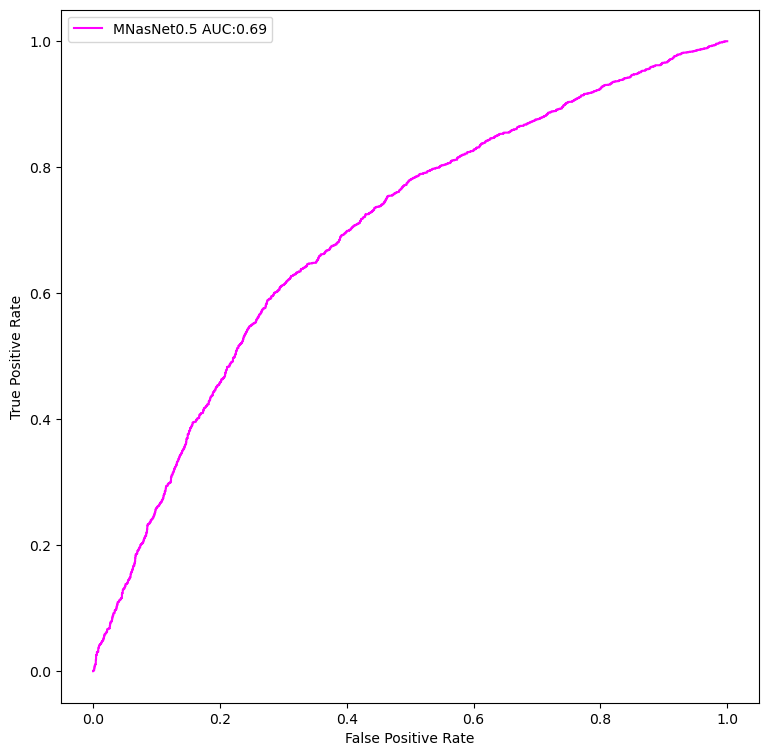

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = roc_curve(val_label, pred_for_roc_curve)
c_ax.plot(fpr, tpr, color='magenta', label = 'MNasNet0.5 AUC:%0.2f'  % (auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("plot1.png")

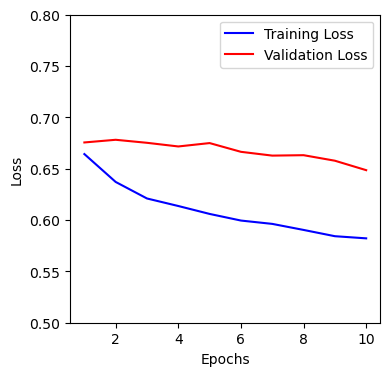

In [26]:
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_xlabel('Epochs')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")

fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_title("VGG19 Loss")
c_ax.set_xlabel('Epochs')
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")